In [51]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer as wnl
from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from string import punctuation
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [101]:
# train = pd.read_csv('data/train_sample.tsv', delimiter = '\t')
train = pd.read_csv('data/train.tsv', delimiter = '\t')

In [3]:
train.head()
# NOTE: category_name --> string, hierarchical (L->R)
# NOTE: brand_name --> string, can this be boolean?
# NOTE: item_description --> string, needs nlp

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
train.columns

Index([u'train_id', u'name', u'item_condition_id', u'category_name',
       u'brand_name', u'price', u'shipping', u'item_description'],
      dtype='object')

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1482535 non-null object
brand_name           1482535 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482535 non-null object
category_top         1482535 non-null object
category_middle      1482535 non-null object
category_bottom      1482535 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
train_id,998.0,498.500000,288.242086,0.0,249.25,498.5,747.75,997.0
item_condition_id,998.0,1.888778,0.916063,1.0,1.00,2.0,3.00,5.0
price,998.0,27.924850,45.903319,3.0,10.00,16.0,29.00,650.0
shipping,998.0,0.449900,0.497733,0.0,0.00,0.0,1.00,1.0


In [102]:
five_condition = train[train['item_condition_id'] == 5]
five_condition.head()
# NOTE: item condition is 1-5 scale where 1 is the best and 5 is the worst

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
653,653,Fossil vintage renewal purse,5,Women/Women's Handbags/Shoulder Bag,Fossil,36.0,0,No description yet
1027,1027,Broken necklace,5,Women/Jewelry/Necklaces,NaN,20.0,1,"10k gold 18"" chain. Broken at clasp."
2436,2436,Gameboy advance sp ags-101 FOR PARTS,5,Other/Other/Other,NaN,24.0,0,For parts . Turns on and hold battery charge ....
2803,2803,"2 Pounds Of ""Junk"" Jewelry",5,Handmade/Jewelry/Jewelry,NaN,11.0,0,"2 pounds of junk jewelry, There are some items..."


In [103]:
max_price = np.max(train['price'])
most_expensive = train[train['price'] == max_price]
most_expensive
min_price = np.min(train['price'])
least_expensive = train[train['price'] == min_price]
least_expensive.head()
# NOTE: There are a lot of items with no cost (874)
# even though they have good condition and require shipping

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...


In [104]:
len(train['brand_name'].value_counts())

4809

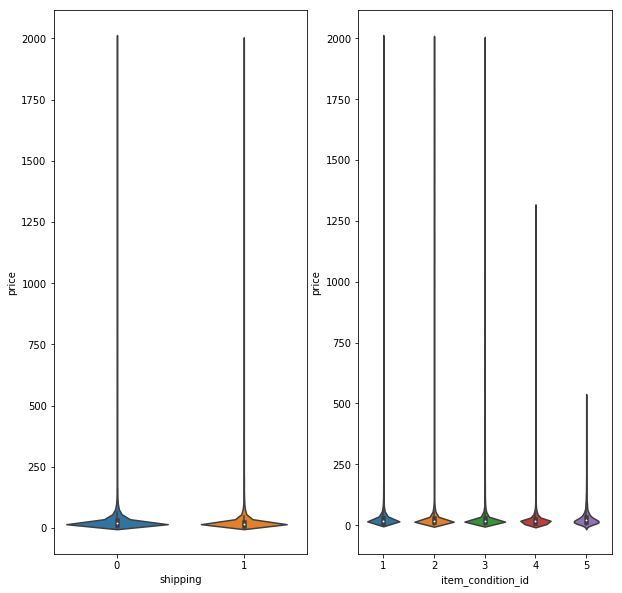

In [105]:
fig, ax_arr = plt.subplots(1,2, figsize=(10,10))
print (ax_arr)
sns.violinplot(train['shipping'], train['price'], ax=ax_arr[0])
sns.violinplot(train['item_condition_id'], train['price'], ax=ax_arr[1])


In [61]:
no_shipping = np.mean(train[train['shipping'] == 0]['price'])
shipping = np.mean(train[train['shipping'] == 1]['price'])
print ('AVG NO SHIPPING: {}'.format((no_shipping)))
print ('AVG WITH SHIPPING: {}'.format((shipping)))

AVG NO SHIPPING: 31.4881602914
AVG WITH SHIPPING: 23.5679287305


In [106]:
train['category_name'] = train['category_name'].fillna('None/None/None')
mask = train['category_name'] == 'None/None/None'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,None/None/None,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,None/None/None,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,None/None/None,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,None/None/None,Michael Kors,18.0,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,None/None/None,Nickelodeon,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."
1274,1274,Black Ribbed Off-the-Shoulder Crop Top,2,None/None/None,Urban Outfitters,15.0,0,From the silence + noise brand sold at Urban O...
1320,1320,Nice Condition Pet Escort,2,None/None/None,PetSafe,12.0,0,Nice condition I will wipe down before selling
1419,1419,3 Toy Bundle,1,None/None/None,NaN,34.0,0,"* brand new/NIB * ** price firm, no free shipp..."
1491,1491,Baby Sign,3,None/None/None,NaN,3.0,1,Magnetic baby sign
1521,1521,Nolan Ryan Patch Baseball Card,2,None/None/None,NaN,3.0,1,No description yet


In [107]:
train['brand_name'] = train['brand_name'].fillna('no_label')
mask = train['brand_name'] == 'no_label'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no_label,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no_label,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,no_label,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,no_label,8.0,0,I realized his pants are on backwards after th...
17,17,New: Baby K'tan active baby carrier,1,Kids/Gear/Backpacks & Carriers,no_label,29.0,1,Brand new in box Size: Medium Color: Coral Ret...
23,23,Triple car charger,1,Electronics/Cell Phones & Accessories/Chargers...,no_label,8.0,1,Brand new never used All colors are available ...
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,50.0,1,No description yet
34,34,Four puppy dog stuffed animal ty,3,Kids/Toys/Stuffed Animals & Plush,no_label,5.0,1,2 beanie babies pugsley wrinkles Puppy with pu...
35,35,Black Capri Leggings w/ Flowers One size,1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,13.0,1,One size fits sizes 2-12 92% polyester 8% span...


In [108]:
train['item_description'] = train['item_description'].fillna('No description yet')
mask = train['item_description'] == 'No description yet'
train[mask]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet
13,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
31,31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",no_label,50.0,1,No description yet
90,90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet
117,117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,no_label,5.0,1,No description yet
129,129,Primitive pillow,2,Home/Home Décor/Home Décor Accents,no_label,9.0,0,No description yet
172,172,Toddler Nike tennis shoes,3,Kids/Boys 0-24 Mos/Shoes,Nike,10.0,0,No description yet
195,195,Black Toms,4,Women/Shoes/Loafers & Slip-Ons,no_label,8.0,1,No description yet
214,214,XXS lularoe Carly,1,Women/Dresses/Asymmetrical Hem,no_label,55.0,1,No description yet
218,218,Scentsy testers (36),3,Home/Home Décor/Home Fragrance,Scentsy,21.0,1,No description yet


In [109]:
top, middle, bottom = [], [], []
for i, row in train.iterrows():
    hierarchy_string = row['category_name']
#     print (hierarchy_string)
    hierarchy_list = hierarchy_string.split('/')
#     print ('1: {}, 2: {}, 3: {}'.format(hierarchy_list[0], hierarchy_list[1], hierarchy_list[2]))
    top.append(hierarchy_list[0])
    middle.append(hierarchy_list[1])
    bottom.append(hierarchy_list[2])
train['category_top'] = top
train['category_middle'] = middle
train['category_bottom'] = bottom

there are 11 top, 114 middle, and 871 bottom categories


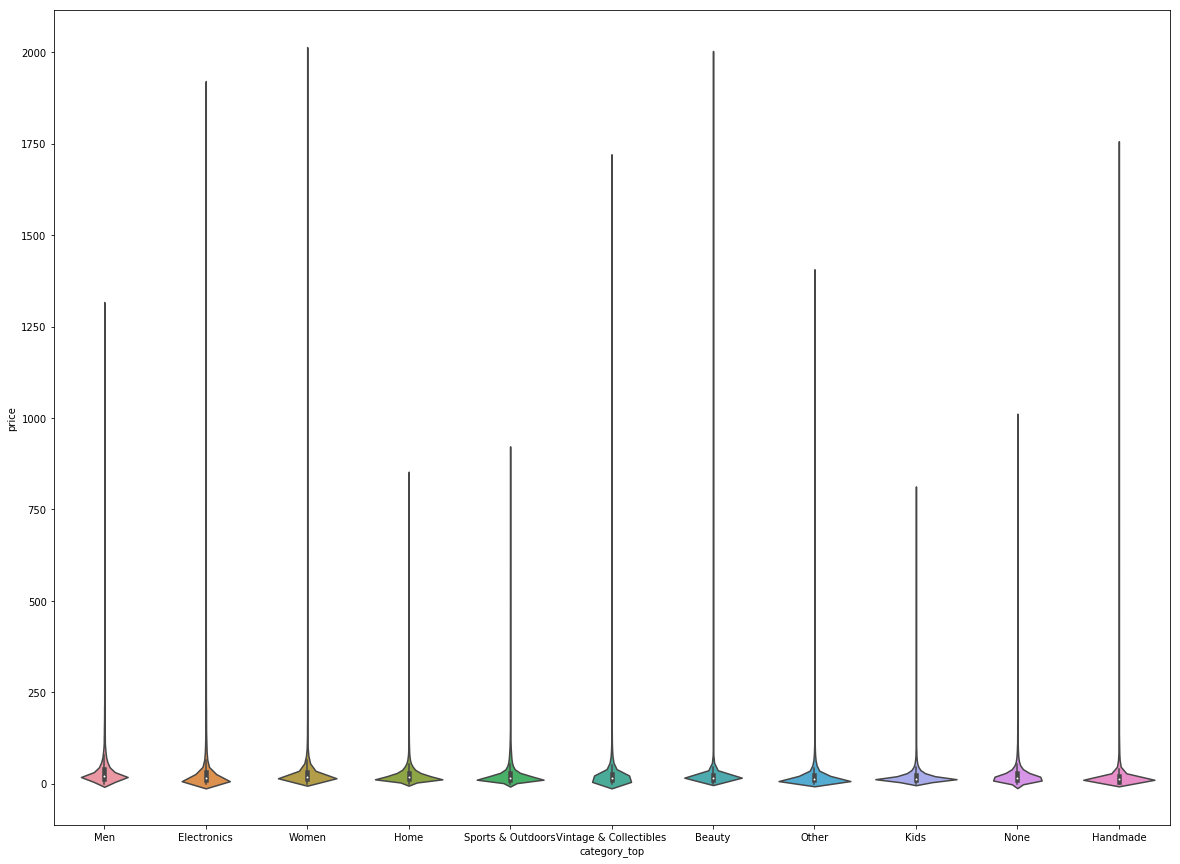

In [110]:
top_count = len(set(top))
middle_count = len(set(middle))
bottom_count = len(set(bottom))
print ('there are {} top, {} middle, and {} bottom categories'.format(top_count, middle_count, bottom_count))

fig, ax_arr = plt.subplots(1,1, figsize=(20,15))
sns.violinplot(train['category_top'], train['price'], ax=ax_arr)

In [16]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_top,category_middle,category_bottom
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,no_label,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,no_label,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,no_label,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [17]:
train['category_middle'].value_counts()

Makeup                       98
Athletic Apparel             83
Shoes                        77
Tops & Blouses               67
Jewelry                      39
Toys                         37
Women's Handbags             32
Cell Phones & Accessories    31
Sweaters                     31
Dresses                      31
Fragrance                    21
Women's Accessories          21
Jeans                        20
Underwear                    20
Kitchen & Dining             18
Boys 0-24 Mos                18
Home Décor                   18
Skin Care                    16
Girls 0-24 Mos               16
Swimwear                     16
Other                        16
Coats & Jackets              15
Girls 2T-5T                  15
Tops                         14
Video Games & Consoles       14
Boys 2T-5T                   12
Daily & Travel items         12
Men's Accessories            11
Tools & Accessories          10
Girls (4+)                    9
                             ..
None    

In [18]:
stop_words = set(stopwords.words('english'))
    
def tokenize(string):
    clean_list = []
    description = string.lower()
    desc_list = description.split()
    for word in desc_list:
        word = word.strip(punctuation)
        if len(word) > 0:
            clean_list.append(word)
    return clean_list

def remove_stopwords(token_list):
    no_stop_words = [word for word in token_list if word not in stop_words]
    return no_stop_words

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(token_list):
    alphabet = set(['a','b','c','d','e','f','g','h','i','j','k','l','m'
                    'n','o','p','q','r','s','t','u','v','w','x','y','z'])
    lemmatizer = wnl()
    lemmed_tokens = []
    tagged = nltk.pos_tag(token_list)
    for word, pos_tag in tagged:
        word = ''.join([letter for letter in word if letter in alphabet])
        lemmed_word = lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos_tag))
        lemmed_tokens.append(lemmed_word)
    return lemmed_tokens

In [19]:
train['description_tokens'] = train['item_description'].apply(lambda x: tokenize(x))

In [20]:
train['description_tokens'] = train['description_tokens'].apply(lambda x: remove_stopwords(x))

In [21]:
train['lemmed_tokens'] = train['description_tokens'].apply(lambda x: lemmatize(x))

In [22]:
vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
vectorizer.fit(train['lemmed_tokens'])
desc_vect = vectorizer.transform(train['lemmed_tokens'])

In [23]:
no_lem_vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
no_lem_vectorizer.fit(train['description_tokens'])
no_lem_vect = no_lem_vectorizer.transform(train['description_tokens'])

In [24]:
no_lem_trunc_svd = TruncatedSVD(n_components=150, n_iter=10)
no_lem_trunc_svd.fit(no_lem_vect)
reduced_no_lem_vect = no_lem_trunc_svd.transform(no_lem_vect)

In [25]:
trunc_svd = TruncatedSVD(n_components=150, n_iter=10)
trunc_svd.fit(desc_vect)
reduced_vect = trunc_svd.transform(desc_vect)

In [26]:
len(no_lem_vectorizer.vocabulary_)

4718

In [27]:
len(vectorizer.vocabulary_)

3836

In [28]:
sum(trunc_svd.explained_variance_ratio_)

0.50855805647644969

In [29]:
lem_train, lem_test, y_lem_train, y_lem_test = train_test_split(reduced_vect,
                                                                train['price'], test_size=0.2)
no_lem_train, no_lem_test, y_no_lem_train, y_no_lem_test = train_test_split(reduced_no_lem_vect, 
                                                                            train['price'], test_size=0.2)

In [30]:
rf_lem = RandomForestRegressor(n_estimators=100, verbose=3)
gb_lem = GradientBoostingRegressor(verbose=3)
rf_no_lem = RandomForestRegressor(n_estimators=100, verbose=3)
gb_no_lem = GradientBoostingRegressor(verbose=3)
gb_lem.fit(lem_train, y_lem_train)
rf_lem.fit(lem_train, y_lem_train)
gb_no_lem.fit(no_lem_train, y_no_lem_train)
rf_no_lem.fit(no_lem_train, y_no_lem_train)

      Iter       Train Loss   Remaining Time 
         1        1614.5140            3.07s
         2        1526.5313            2.70s
         3        1454.0713            2.21s
         4        1394.4835            1.92s
         5        1297.9584            1.80s
         6        1236.1224            1.73s
         7        1144.1610            1.66s
         8        1084.1881            1.64s
         9         998.9813            1.57s
        10         946.6601            1.50s
        11         909.1009            1.43s
        12         866.4856            1.39s
        13         829.5174            1.38s
        14         783.1527            1.35s
        15         750.2353            1.34s
        16         732.2512            1.31s
        17         703.3865            1.31s
        18         676.8230            1.28s
        19         661.5828            1.24s
        20         640.5542            1.21s
        21         611.8652            1.18s
        2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.1s finished


         2        1850.7385            2.49s
         3        1761.2505            2.58s
         4        1680.7236            2.24s
         5        1640.7774            1.99s
         6        1553.9131            1.82s
         7        1483.5530            1.77s
         8        1447.1756            1.69s
         9        1390.1400            1.61s
        10        1360.2598            1.59s
        11        1335.6342            1.62s
        12        1294.8176            1.63s
        13        1267.3946            1.62s
        14        1235.0773            1.61s
        15        1200.2329            1.63s
        16        1183.4723            1.61s
        17        1161.0075            1.58s
        18        1148.0133            1.57s
        19        1127.5509            1.54s
        20        1102.5238            1.52s
        21        1088.8579            1.49s
        22        1080.3857            1.47s
        23        1069.6983            1.44s
        24

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=3, warm_start=False)

In [34]:
print 'Gradient Boosted lemmatized R**2 score: {}'.format(gb_lem.score(lem_train, y_lem_train))
print 'Random Forest lemmatized R**2 score: {}'.format(rf_lem.score(lem_train, y_lem_train))
print 'Gradient Boosted non-lemmatized R**2 score: {}'.format(gb_no_lem.score(no_lem_train, y_no_lem_train))
print 'Random Forest non-lemmatized R**2 score: {}'.format(rf_no_lem.score(no_lem_train, y_no_lem_train))

Gradient Boosted lemmatized R**2 score: 0.897235124908
Random Forest lemmatized R**2 score: 0.828382179582
Gradient Boosted non-lemmatized R**2 score: 0.691811236323
Random Forest non-lemmatized R**2 score: 0.623793050391


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [112]:
train[train['price'] > 400].sort_values('price', ascending=False)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_top,category_middle,category_bottom
760469,760469,NEW Chanel WOC Caviar Gold Hardware,1,Women/Women's Handbags/Shoulder Bag,Chanel,2009.0,0,"New with tag, box and dustbag but no receipt. ...",Women,Women's Handbags,Shoulder Bag
1262245,1262245,NEW-Chanel Boy Wallet o Chain WOC Caviar,1,Women/Women's Handbags/Messenger & Crossbody,Chanel,2006.0,0,Brand: Chanel Style: WOC Boy Wallet on Chain T...,Women,Women's Handbags,Messenger & Crossbody
1393600,1393600,David Yurman Wheaton ring,2,Women/Jewelry/Rings,David Yurman,2004.0,0,David Yurman Wheaton wing. Size 6. Original re...,Women,Jewelry,Rings
1250053,1250053,Brand New Chanel CC Quilted WOC,2,Women/Women's Handbags/Messenger & Crossbody,Chanel,2000.0,1,This is a brand new Chanel CC Quilted Wallet o...,Women,Women's Handbags,Messenger & Crossbody
742113,742113,Chanel Chevron Fuschia Pink 2,1,Women/Women's Handbags/Shoulder Bag,Chanel,2000.0,1,Authentic Brand new The price for this is [rm]...,Women,Women's Handbags,Shoulder Bag
1445348,1445348,Vs2/I 1ct Diamond Engagement Ring,2,Women/Jewelry/Rings,no_label,2000.0,1,Absolutely stunning diamond engagement ring Pu...,Women,Jewelry,Rings
956343,956343,Chanel Black wallet on chain,1,Women/Women's Handbags/Messenger & Crossbody,Chanel,2000.0,1,Lambskin Color is Black with dark Silver Hardw...,Women,Women's Handbags,Messenger & Crossbody
415027,415027,Chanel Classic Jumbo Single flap bag,3,Women/Women's Handbags/Shoulder Bag,Chanel,2000.0,1,Authentic. Pre-loved in Excellent Condition. P...,Women,Women's Handbags,Shoulder Bag
778940,778940,Mary kay,1,Beauty/Makeup/Face,Mary Kay,2000.0,1,30 time wise sets Oily to combo skin,Beauty,Makeup,Face
952000,952000,Chanel J12 H0682 Wrist Watch for Women,3,Women/Women's Accessories/Watches,no_label,1999.0,1,"HELLO , I HAVE A BLACK CHANEL WATCH J12 CERAMI...",Women,Women's Accessories,Watches
